In [26]:
import cv2
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
import matplotlib.pyplot as plt 
from skimage.transform import resize
import numpy as np
from tensorflow.keras.layers import RepeatVector , Reshape 
from PIL import Image

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights('./data/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
inception.graph = tf.get_default_graph()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
#To generate embeddings of 1000*1 by passing input images through InceptionResNetV2
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed
import tensorflow as tf

In [6]:
from tensorflow import keras
model = keras.models.load_model('./color_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 128, 128, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 128, 128, 128 73856       conv2d_203[0][0]                 
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 64, 64, 128)  147584      conv2d_204[0][0]                 
______________________________________________________________________________________________

In [28]:
# Util functions

def lab2RGB(l, ab):
    shape = (l.shape[0],l.shape[1],3)
    img = np.zeros(shape)
    img[:,:,0] = l[:,:,0]
    img[:,:,1:] = ab
    img = img.astype('uint8')
    print(img.max())
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img
def display(img):
    plt.figure()
    plt.set_cmap('gray')
    plt.imshow(img)
    plt.show()

def get_RGB(image_l, image_ab  ):
       
    image_l = image_l.reshape((256, 256, 1))
    image_lab = np.concatenate((image_l, image_ab), axis=2)
    image_lab = image_lab.astype("uint8")
 
    image_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
    image_rgb = Image.fromarray(image_rgb)
    return image_rgb





In [41]:
def get_rgb_prediction(img_path):
    test_img = cv2.imread(img_path)
    rgb_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    print (rgb_img.shape)

    display(rgb_img)

    img_lab = rgb2lab(test_img)
    img_lab = resize(img_lab, (256, 256, 3), mode='constant')
    
    img_lab = np.array(img_lab)
    
    img_lab_one = img_lab

    img_l = img_lab_one[:, :, 0]
    img_ab = img_lab_one[:, :, 1:]


    display(img_l)

    incept_em = create_inception_embedding([img_l])
    embeddings = RepeatVector(32 * 32)(incept_em)
    layer_embedding_test = Reshape(([32, 32, 1000]))(embeddings)

    img_l = img_l.reshape((1, 256, 256, 1))

    output = model.predict([img_l,layer_embedding_test],steps=3)

    output = output * 128
    pred_rgb = get_RGB(img_l[0],output[0])
   
    return pred_rgb

(256, 256, 3)


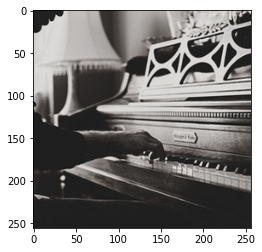

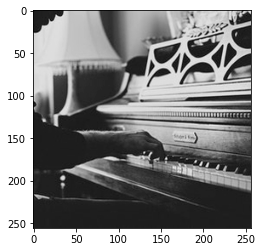

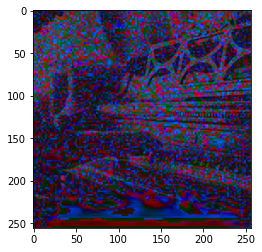

In [42]:
rgb_prediction = get_rgb_prediction('./data/images/Test/0RQqeI.jpg')
display(rgb_prediction)